In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns
from typing import List

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql import Window
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, lag, lead, avg, count, unix_timestamp
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, Bucketizer
from pyspark.ml.stat import Correlation

MAX_MEMORY = '12G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 60000) \
        .set('spark.network.timeout', 60000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab1_Mironov") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

directory_path = "data/"

file_list = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

# Чтение файлов и создание DataFrame с явным указанием разделителя
dataframes = [spark.read.csv(os.path.join(directory_path, file), header=True, inferSchema=True, sep=';') for file in file_list]

# Объединение DataFrame в один
merged_dataframe = reduce(DataFrame.union, dataframes)

# Вывод первых строк объединенного DataFrame
merged_dataframe.limit(5).toPandas().head()

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95
0,2014-07-19 18:45:00,1,0,51.625703,22.712489,52.816828,53.501688,54.079161,52.683472,52.590445,...,81.286349,77.580181,58.433449,55.572970,53.792765,51.999028,43.290921,34.161343,28.349901,24.636241
1,2014-07-19 19:30:00,1,0,52.281257,6.618605,51.452796,51.676287,51.329882,51.690879,51.538671,...,55.571058,53.791009,51.997415,43.289440,34.159983,28.348652,24.635094,19.147728,12.982840,7.928666
2,2014-07-19 20:00:00,1,0,50.719565,1.452209,51.313898,52.199835,52.340547,51.844138,52.661063,...,51.996045,43.288181,34.158827,28.347590,24.634119,19.146832,12.982018,7.927911,5.622566,3.299011
3,2014-07-19 20:15:00,1,0,51.901162,0.580877,51.950475,51.624345,50.867434,51.538997,51.331161,...,43.288060,34.158716,28.347489,24.634026,19.146747,12.981939,7.927839,5.622499,3.298950,2.130662
4,2014-07-19 21:00:00,1,0,51.250007,0.000000,52.218820,52.176852,51.745211,51.809854,51.835710,...,24.633942,19.146670,12.981869,7.927774,5.622440,3.298896,2.130612,1.352937,1.246175,1.246205


In [3]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (nullable = true

In [4]:
merged_dataframe = merged_dataframe.select('timestamp', 'site_id', 'period_id', 
                                           'actual_consumption', 'actual_pv', 
                                           'load_00', 'load_15', 'load_30', 'load_45', 'load_60', 'load_75', 'load_90',
                                           'pv_00', 'pv_15', 'pv_30', 'pv_45', 'pv_60', 'pv_75', 'pv_90')
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_30: double (nullable = true)
 |-- load_45: double (nullable = true)
 |-- load_60: double (nullable = true)
 |-- load_75: double (nullable = true)
 |-- load_90: double (nullable = true)
 |-- pv_00: double (nullable = true)
 |-- pv_15: double (nullable = true)
 |-- pv_30: double (nullable = true)
 |-- pv_45: double (nullable = true)
 |-- pv_60: double (nullable = true)
 |-- pv_75: double (nullable = true)
 |-- pv_90: double (nullable = true)



In [5]:
# Вывод количества строк до удаления пустых значений
merged_dataframe.count()

962282

In [6]:
# Вывод количества уникальных значений
merged_dataframe.agg(*(countDistinct(col(c)).alias(c) for c in merged_dataframe.columns)).show()

+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+
|timestamp|site_id|period_id|actual_consumption|actual_pv|load_00|load_15|load_30|load_45|load_60|load_75|load_90| pv_00| pv_15| pv_30| pv_45| pv_60| pv_75| pv_90|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+
|   160155|     15|      121|            218567|   415202| 935757| 889831| 865872| 864623| 861604| 856843| 848347|460535|586080|707477|762997|682287|577344|470103|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+



In [7]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = merged_dataframe.dropna()

# Вывод количество строк после удаления пустых значений
cleaned_dataframe.count()

962282

In [8]:
cleaned_dataframe_short = cleaned_dataframe.select('timestamp', 
                                           'actual_consumption', 'actual_pv', 
                                           'load_00', 'load_15', 'load_30', 'load_45', 'load_60', 'load_75', 'load_90',
                                           'pv_00', 'pv_15', 'pv_30', 'pv_45', 'pv_60', 'pv_75', 'pv_90')
# Расчет статистических показателей
statistics_summary = cleaned_dataframe_short.describe()
# Вывод сводной статистики
statistics_summary.toPandas()

,summary,actual_consumption,actual_pv,load_00,load_15,load_30,load_45,load_60,load_75,load_90,pv_00,pv_15,pv_30,pv_45,pv_60,pv_75,pv_90
0,count,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282
1,mean,84.97831477402282,48.8092741083705,85.00599846857008,85.10565482160662,85.12443175218424,85.11599274214572,85.10483050524424,85.09376480393688,85.08681957936204,48.49059524394483,48.199186042706515,48.14666818612125,48.15277302271655,48.149903858099016,48.13445646144346,48.13508089624981
2,stddev,90.95467181105728,106.05339543174317,90.19442371066482,87.99275987898248,87.56497863223683,87.44294159822654,87.41210893911524,87.41038192463103,87.40862314634927,103.15892191702888,99.19403077857409,98.9835767976478,98.98262885829101,98.95805720714918,98.94086311514276,98.94528392425563
3,min,0.14690635762456802,0.0,-263.0548926545911,-155.96820227035502,-77.01650584821391,-27.57016976268804,0.2073588179345237,0.2073588179345237,0.2073588179345237,-143.22771168370699,-100.58732941771692,-62.081428145499025,-33.60618585526658,-13.955224017932785,-10.848267713854076,-9.389647857219241
4,max,652.1130937616396,755.3993506760426,971.6318758657195,671.5080583034877,612.8989551725509,605.4328579504138,605.4255613911822,605.425599958934,605.425597987754,837.1003312739387,726.3585145875701,715.709802626299,715.7096707725276,715.7096701795634,715.7096701769219,715.7096701768833


## Выводы по сводной статистике:

actual_consumption: Среднее значение около 84.98, со стандартным отклонением около 90.95. Минимальное значение 0.15, а максимальное - 652.11. Возможно, это признак потребления энергии с некоторыми выбросами.

actual_pv: Среднее значение около 48.81, со стандартным отклонением около 106.05. Этот признак также представляет собой потребление энергии, с более широким разбросом.

load_00, load_15, load_30, load_45, load_60, load_75, load_90: Все эти признаки кажутся похожими, причем у них высокие средние значения и стандартные отклонения, что может свидетельствовать о значительных колебаниях.

pv_00, pv_15, pv_30, pv_45, pv_60, pv_75, pv_90: Аналогично признакам load, эти признаки также имеют высокие средние значения и стандартные отклонения.

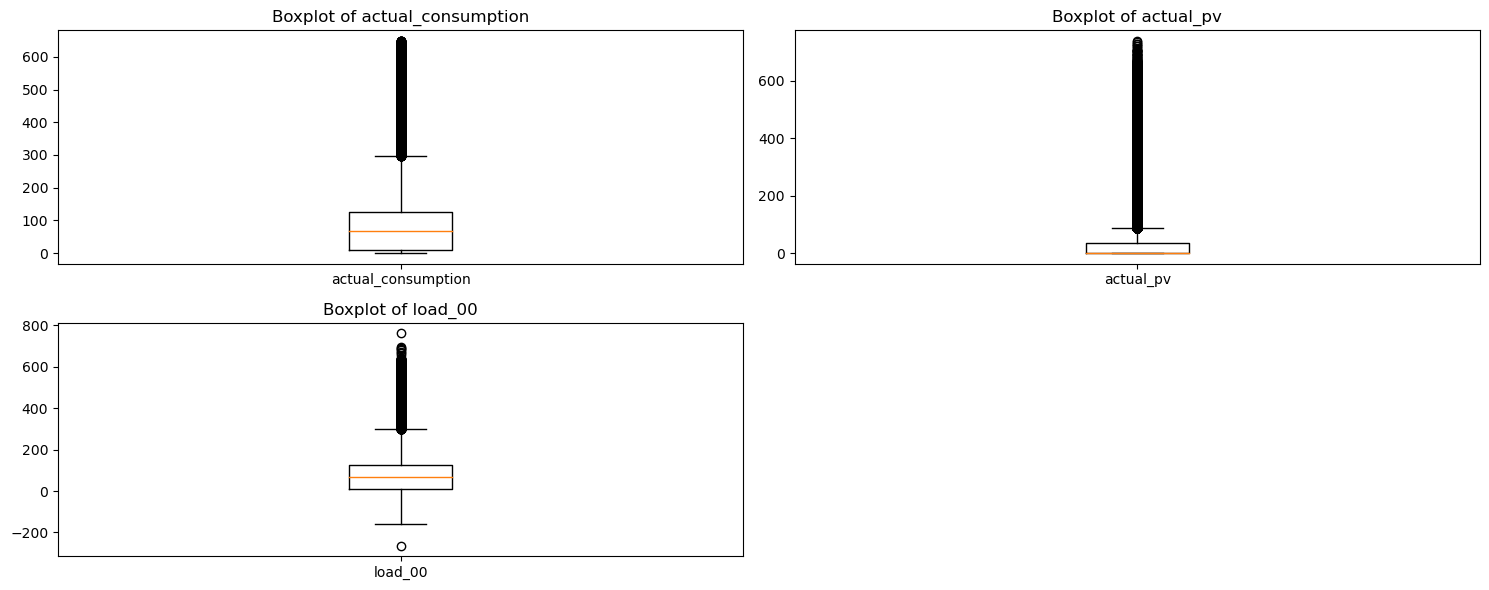

In [9]:
def print_columns_box_plots(dataframe, columns_to_print, sample_fraction=0.1, number_of_cols=2):
    # Определение количества строк и столбцов для Subplots
    num_rows = len(columns_to_print) // number_of_cols + (len(columns_to_print) % number_of_cols > 0)
    
    # Сэмплируем и преобразуем PySpark DataFrame в Pandas DataFrame
    sampled_pandas_df = dataframe.select(columns_to_print).sample(fraction=sample_fraction, seed=42).toPandas()
    
    fig, axs = plt.subplots(num_rows, number_of_cols, figsize=(15, 3 * num_rows))
    
    for i, column in enumerate(columns_to_print):
        # Построение boxplot
        axs[i // number_of_cols, i % number_of_cols].boxplot(sampled_pandas_df[column], labels=[column])
        axs[i // number_of_cols, i % number_of_cols].set_title(f'Boxplot of {column}')
    
    # Убираем пустые подграфики, если количество не кратно number_of_cols
    for i in range(len(columns_to_print), num_rows * number_of_cols):
        fig.delaxes(axs.flatten()[i])
    
    # Регулировка расположения подграфиков
    plt.tight_layout()
    
    # Отображение графика
    plt.show()
    
# Список столбцов для обработки
columns_to_filter = ['actual_consumption', 'actual_pv', 'load_00']
print_columns_box_plots(cleaned_dataframe, columns_to_filter)

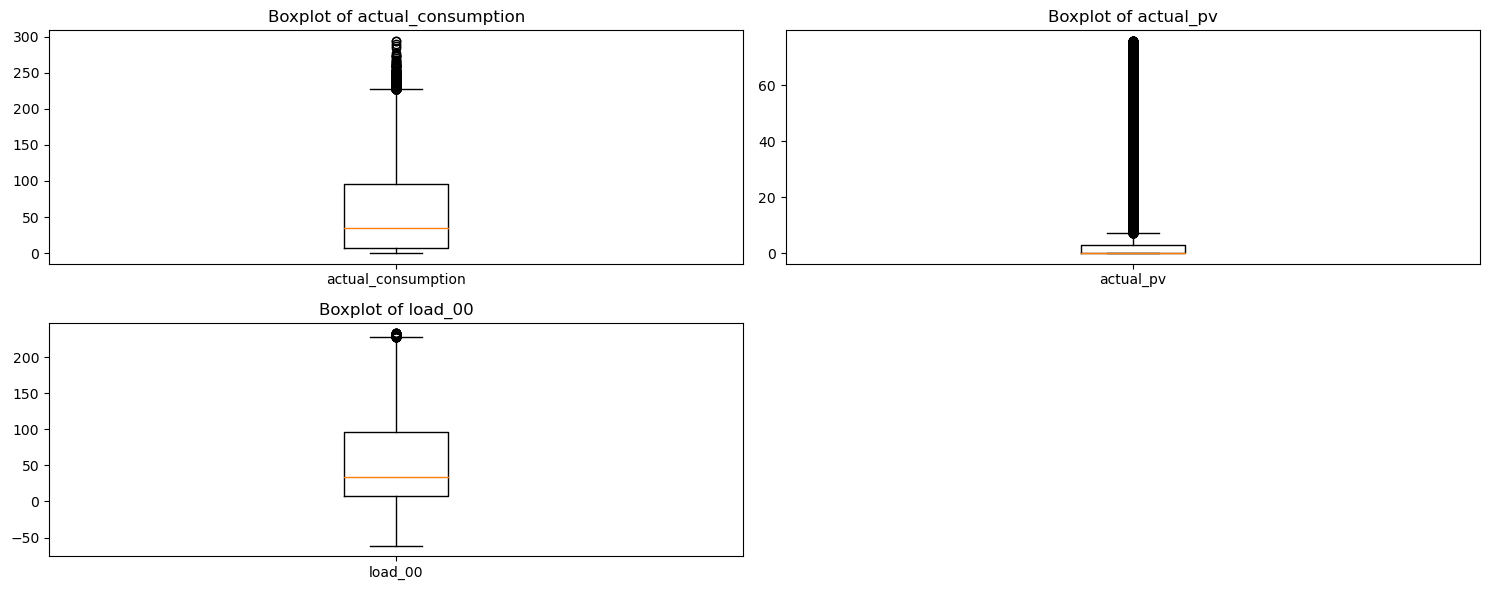

In [10]:
# Фильтрация выбросов для каждого столбца
for column in columns_to_filter:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

print_columns_box_plots(cleaned_dataframe, columns_to_filter)

<BarContainer object of 17 artists>

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

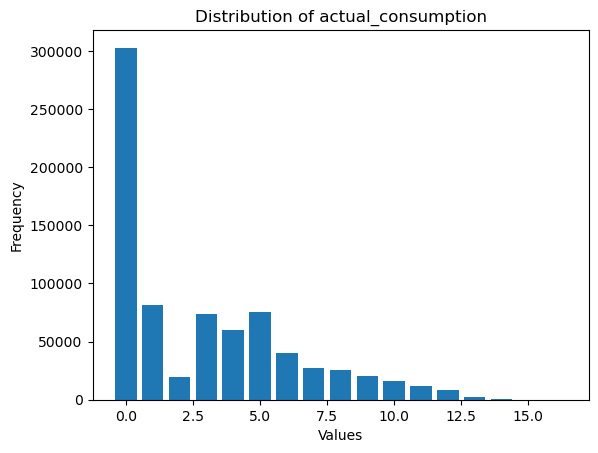

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

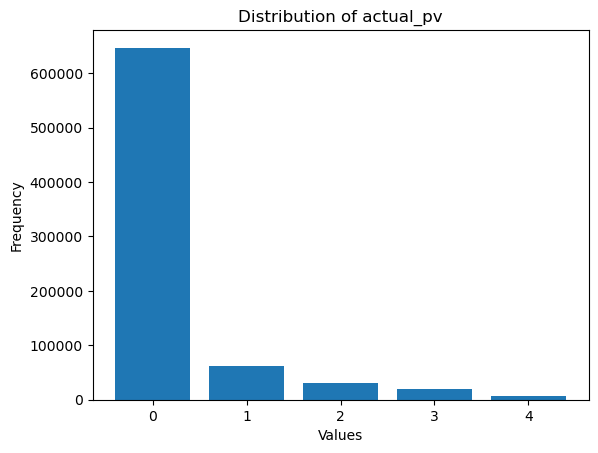

<BarContainer object of 14 artists>

Text(0.5, 1.0, 'Distribution of load_00')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

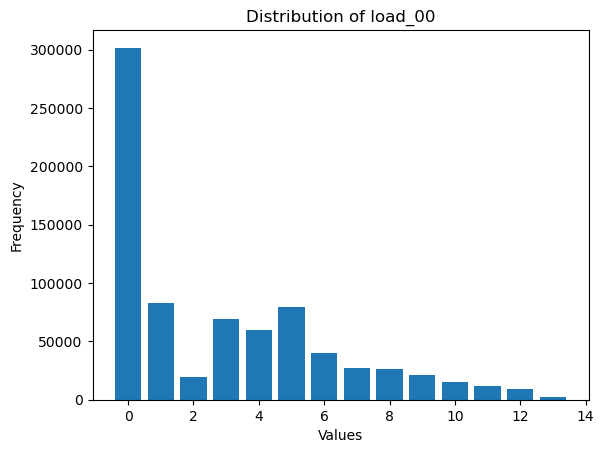

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of load_90')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

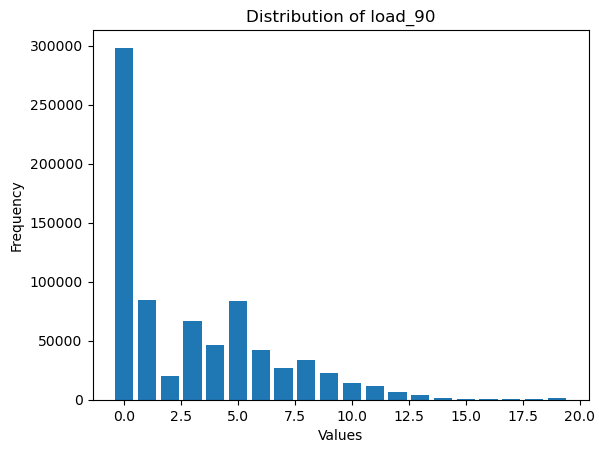

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of pv_00')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

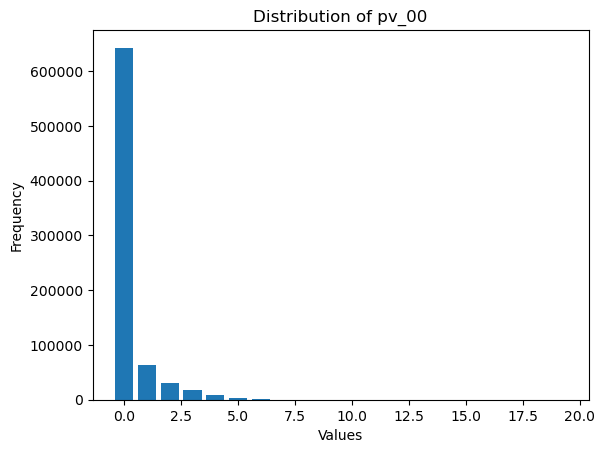

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of pv_90')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

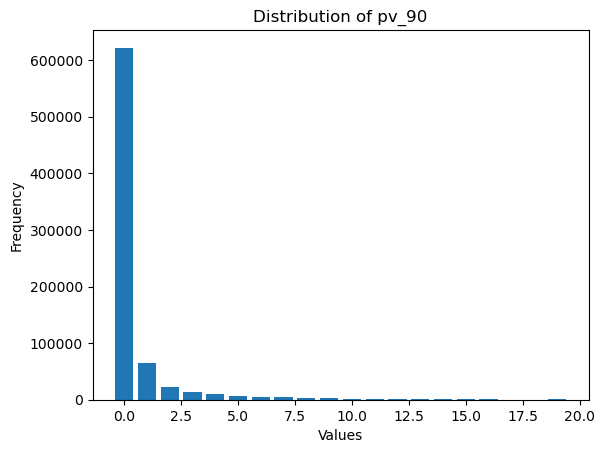

In [11]:
selected_features = ['actual_consumption', 'actual_pv', 'load_00', 'load_90', 'pv_00', 'pv_90'] 

num_buckets = 20
step = 350 / num_buckets
splits = [float("-inf")] + [i * step for i in range(1, num_buckets)] + [float("inf")]
# Построение гистограммы для каждой колонки
for selected_column in selected_features:
    bucketizer = Bucketizer(splits=splits, inputCol=selected_column, outputCol="bucketizer")
    df_bucket = bucketizer.transform(cleaned_dataframe)
    bucket_counts = df_bucket.groupBy("bucketizer").count().orderBy("bucketizer")
    bucket_counts_pd = bucket_counts.toPandas()
    plt.bar(bucket_counts_pd["bucketizer"], bucket_counts_pd["count"], align="center", label=selected_column)
    plt.title(f"Distribution of {selected_column}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'Distribution of site_id')

Text(0.5, 0, 'site_id')

Text(0, 0.5, 'Count')

<BarContainer object of 121 artists>

Text(0.5, 1.0, 'Distribution of period_id')

Text(0.5, 0, 'period_id')

Text(0, 0.5, 'Count')

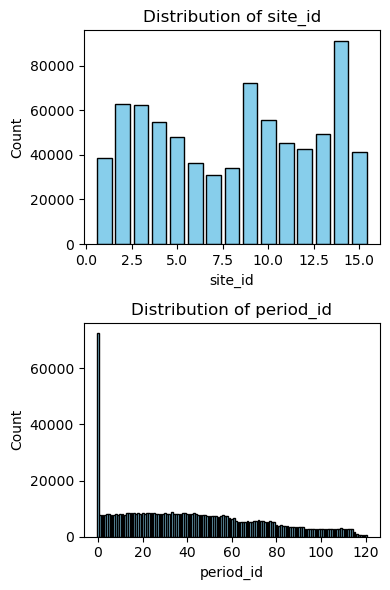

In [12]:
selected_features = ['site_id', 'period_id'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(4, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    axs[i].bar(categories, counts, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

In [13]:
# Создаем VectorAssembler для объединения признаков в один вектор
feature_cols = ['load_00', 'load_15', 'load_30', 'load_45', 'load_60', 'load_75', 'load_90', 'pv_00', 'pv_15', 'pv_30', 'pv_45', 'pv_60', 'pv_75', 'pv_90']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(cleaned_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=feature_cols)

In [14]:
correlation_df.corr()

,load_00,load_15,load_30,load_45,load_60,load_75,load_90,pv_00,pv_15,pv_30,pv_45,pv_60,pv_75,pv_90
load_00,1.000000,0.833228,0.754600,0.768492,0.793464,0.838140,0.956564,-0.271630,0.036510,0.175470,0.278496,0.271834,0.153338,-0.108617
load_15,0.833228,1.000000,0.945105,0.797343,0.609202,0.539865,0.691197,-0.380576,0.384345,0.627469,0.504127,0.009429,-0.294207,-0.483957
load_30,0.754600,0.945105,1.000000,0.913767,0.712801,0.576832,0.645959,-0.559154,0.233147,0.623991,0.706568,0.191344,-0.271245,-0.602539
load_45,0.768492,0.797343,0.913767,1.000000,0.921063,0.801577,0.757218,-0.692778,-0.094288,0.352425,0.725073,0.524326,0.063947,-0.490126
load_60,0.793464,0.609202,0.712801,0.921063,1.000000,0.959891,0.869430,-0.623772,-0.355994,0.018095,0.541455,0.698370,0.395476,-0.203730
load_75,0.838140,0.539865,0.576832,0.801577,0.959891,1.000000,0.939582,-0.470907,-0.399612,-0.143690,0.336173,0.665995,0.528534,0.011026
load_90,0.956564,0.691197,0.645959,0.757218,0.869430,0.939582,1.000000,-0.305722,-0.171420,-0.011061,0.248308,0.432741,0.353834,0.017869
pv_00,-0.271630,-0.380576,-0.559154,-0.692778,-0.623772,-0.470907,-0.305722,1.000000,0.231501,-0.334006,-0.821960,-0.677039,-0.177922,0.567145
pv_15,0.036510,0.384345,0.233147,-0.094288,-0.355994,-0.399612,-0.171420,0.231501,1.000000,0.750724,-0.064530,-0.773942,-0.803672,-0.446774
pv_30,0.175470,0.627469,0.623991,0.352425,0.018095,-0.143690,-0.011061,-0.334006,0.750724,1.000000,0.566151,-0.396464,-0.807254,-0.794179


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

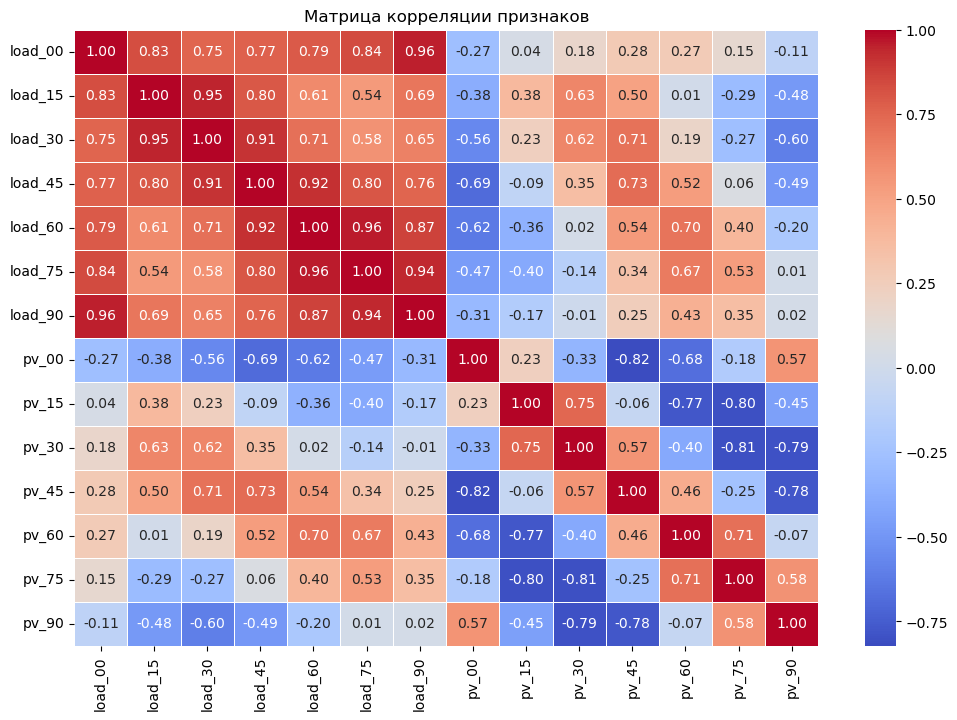

In [15]:
# Строим тепловую карту корреляции с использованием Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [16]:
# Закрываем сессию Spark
spark.stop()